In [1]:
!nvidia-smi

Tue Jul 26 14:08:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   61C    P0   208W / 300W |  23899MiB / 32505MiB |     91%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead
from models.head.classifier import LinearClassifier

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

from easydict import EasyDict as edict
from torch.utils.data import DataLoader

In [4]:
hashs =[("2022-07-02_08-00-31", "2022-07-03_13-41-32"),
        ("2022-07-02_08-00-57", "2022-07-03_13-37-29"),
        ("2022-07-02_09-38-52", "2022-07-03_13-33-23"),
        ("2022-07-02_09-40-42", "2022-07-03_13-29-10"),
        ("2022-07-02_11-17-38", "2022-07-03_13-25-05"),
        ("2022-07-02_11-20-21", "2022-07-03_13-21-00"),
        ("2022-07-02_17-15-14", "2022-07-03_13-16-54"),
        ("2022-07-02_17-15-34", "2022-07-03_13-12-44"),
        ("2022-07-02_18-53-46", "2022-07-03_13-08-35"),
        ("2022-07-02_18-54-27", "2022-07-03_13-04-32")]

In [5]:
gpus = ['3']
server = 'dgx'

In [6]:
hash = hashs[0]

In [7]:
config = edict()
config.server = server
config.gpus = gpus
local_rank = 0

config.finetune_file = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/ckpt.last.pth.tar')
finetune_config = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/configs.json')
with open(finetune_config, 'rb') as fb:
    finetune_config = json.load(fb)

finetune_config_names = [
    # data_parser
    'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
    'image_size', 'small_kernel', 'random_state',
    'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
    # model_parser
    'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
    'arch', 'no_max_pool',
    # train
    'batch_size',
    # moco / supmoco
    'alphas',
    # others
    'task', 'projector_dim'
]

for name in finetune_config_names:
    if name in finetune_config.keys():
        setattr(config, name, finetune_config[name])

In [25]:
set_gpu(config)
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
torch.cuda.set_device(local_rank)

# Networks
if config.backbone_type == 'densenet':
    backbone = DenseNetBackbone(in_channels=1,
                                init_features=config.init_features,
                                growth_rate=config.growth_rate,
                                block_config=config.block_config,
                                bn_size=config.bn_size,
                                dropout_rate=config.dropout_rate,
                                semi=False)
    activation = True
elif config.backbone_type == 'resnet':
    backbone = build_resnet_backbone(arch=config.arch,
                                     no_max_pool=config.no_max_pool,
                                     in_channels=1,
                                     semi=False)
    activation = False
else:
    raise NotImplementedError

if config.small_kernel:
    backbone._fix_first_conv()

if config.crop:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
else:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
classifier = LinearClassifier(in_channels=out_dim, num_classes=2, activation=activation)

backbone.load_weights_from_checkpoint(path=config.finetune_file, key='backbone')
classifier.load_weights_from_checkpoint(path=config.finetune_file, key='classifier')

# load finetune data
data_processor = BrainProcessor(root=config.root,
                                data_info=config.data_info,
                                data_type=config.data_type,
                                mci_only=config.mci_only,
                                random_state=config.random_state)
datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

# intensity normalization
assert config.intensity in [None, 'scale', 'minmax']
mean_std, min_max = (None, None), (None, None)
if config.intensity is None:
    pass
elif config.intensity == 'scale':
    pass
elif config.intensity == 'minmax':
    with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
        minmax_stats = pickle.load(fb)
        min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
else:
    raise NotImplementedError

train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                  intensity=config.intensity,
                                                  mean_std=mean_std,
                                                  min_max=min_max,
                                                  crop=config.crop,
                                                  crop_size=config.crop_size,
                                                  rotate=config.rotate,
                                                  flip=config.flip,
                                                  affine=config.affine,
                                                  blur=config.blur,
                                                  blur_std=config.blur_std,
                                                  prob=config.prob)

train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)

In [26]:
from monai.visualize import (
    GradCAMpp,
    OcclusionSensitivity,
    SmoothGrad,
    GuidedBackpropGrad,
    GuidedBackpropSmoothGrad,
)

In [27]:
class ModelViz(nn.Module):
    def __init__(self, local_rank):
        super(ModelViz, self).__init__()
        self.local_rank = local_rank
    
    def _build_model(self, backbone, classifier):
    
        self.backbone = backbone
        self.classifier = classifier
        
        self.backbone.to(self.local_rank)
        self.classifier.to(self.local_rank)
        
        self.backbone.eval()
        self.classifier.eval()
        
    def forward(self, x):
        logits = self.classifier(self.backbone(x))
        return logits

In [28]:
model = ModelViz(local_rank)
model._build_model(backbone, classifier)

## Check evaluation performance and prediction probability

In [29]:
from utils.metrics import classification_result

In [30]:
@torch.no_grad()
def evaluate(model, data_loader, local_rank=0, adjusted=False):
    """Evaluation defined for a single epoch."""

    steps = len(data_loader)
    model.backbone.eval()
    model.classifier.eval()
    y_true, y_pred = [], []
    for i, batch in enumerate(data_loader):
        x = batch['x'].float().to(local_rank)
        y = batch['y'].to(local_rank)
        logits = model(x)        
        y_true.append(y.long())
        y_pred.append(logits)

    # accuracy and macro f1 score
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0).to(torch.float32)

    clf_result = classification_result(y_true=y_true.cpu().numpy(),
                                       y_pred=y_pred.softmax(1).detach().cpu().numpy(),
                                       adjusted=adjusted)
    result = {}
    for k, v in clf_result.items():
        result[k] = v

    return result

In [31]:
eval_result = evaluate(model=model, data_loader=test_loader, local_rank=0, adjusted=True)
print(eval_result)

{'acc': 0.875, 'auroc': 0.9382113821138212, 'sens': 0.7999999946666667, 'spec': 0.902439022189173, 'prec': 0.7499999953125, 'f1': 0.774193493444332, 'gmean': 0.84967712275801}


In [32]:
@torch.no_grad()
def sample_prediction(model, data_loader, local_rank=0, adjusted=False):
    """Evaluation defined for a single epoch."""

    steps = len(data_loader)
    model.backbone.eval()
    model.classifier.eval()
    y_true, y_pred = [], []
    idx = []
    for i, batch in enumerate(data_loader):
        x = batch['x'].float().to(local_rank)
        y = batch['y'].to(local_rank)
        
        logits = model(x)        
        y_true.append(y.long())
        y_pred.append(logits)
        idx.append(batch['idx'])

    # accuracy and macro f1 score
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0).to(torch.float32)
    idx = torch.cat(idx, dim=0)
    return y_true, y_pred, idx

In [33]:
y_true, y_pred, idx = sample_prediction(model, test_loader)

In [34]:
pmci_idx, smci_idx = [], []
for t, p, i in zip(y_true, y_pred.softmax(1), idx):
    if torch.argmax(p) == t:
        if t == 0:
            if p[t].item() > 0.95:
                smci_idx.append(i.item())
        if t == 1:
            if p[t].item() > 0.95:
                pmci_idx.append(i.item())

In [46]:
target_layer = 'backbone.layer2'
batch_size = 16
divisible_factor = 8

gradcampp = GradCAMpp(model, target_layers=target_layer)
occ_sens = OcclusionSensitivity(
    model, mask_size=8, n_batch=batch_size, stride=divisible_factor, per_channel=False, verbose=False,
)
smooth_grad = SmoothGrad(model, verbose=False)
guided_vanilla = GuidedBackpropGrad(model)
guided_smooth = GuidedBackpropSmoothGrad(model, verbose=False)

In [47]:
def saliency(model, d, device):
    ims = []
    titles = []
    log_scales = []

    img = torch.as_tensor(d["x"])[None].to(device)
    pred_logits = model(img)
    pred_label = pred_logits.argmax(dim=1).item()
    pred_prob = int(torch.nn.functional.softmax(pred_logits, dim=1)[0, pred_label].item() * 100)
    # Image
    ims.append(torch.moveaxis(img, 1, -1))
    titles.append(f"Pred: {pred_label} ({pred_prob}%) | True: {d['y']}")
    log_scales.append(False)

    # Occlusion sensitivity images
    occ_map = occ_sens(img)[0][0]
    ims.append(occ_map[..., pred_label])
    titles.append("Occ. sens.")
    log_scales.append(False)

    # GradCAM
    res_cam_pp = gradcampp(x=img, class_idx=pred_label)[0]
    ims.append(res_cam_pp)
    titles.append("GradCAMpp")
    log_scales.append(False)

    # other gradient-based approaches
    for method, name in zip(
        (smooth_grad, guided_vanilla, guided_smooth),
        ("Smooth", "GuidedVa", "GuidedSm")
    ):
        out = method(img)
        out = torch.sum(out ** 2, dim=1) ** 0.5  # RGB -> scalar
        ims.append(out)
        titles.append(name)
        log_scales.append(True)

    return ims, titles, log_scales

In [48]:
def add_im(im, title, log_scale, row, col, num_examples):
    ax = axes[row, col] if num_examples > 1 else axes[col]
    if isinstance(im, torch.Tensor):
        im = im.detach().cpu()
    if log_scale:
        im_show = ax.imshow(im[0], cmap='jet', norm=colors.LogNorm())
        title += " log"
    else:
        im_show = ax.imshow(im[0], cmap='jet')
    ax.set_title(title)
    ax.axis("off")
    if col > 0:
        fig.colorbar(im_show, ax=ax)


def add_row(ims, titles, log_scales, row, axes, num_examples):
    for col, (im, title, log_scale) in enumerate(zip(ims, titles, log_scales)):
        if log_scale and im.min() < 0:
            im -= im.min()
        ##        
        IMG = im[:, 32, :]
        ##
        add_im(IMG, title, log_scale, row, col, num_examples)

In [49]:
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from matplotlib import colors

test_subset = Subset(test_set, pmci_idx)
num_examples = len(test_subset)
test_subset = np.random.choice(test_subset, replace=False, size=num_examples)

100%|██████████| 8/8 [01:13<00:00,  9.16s/it]


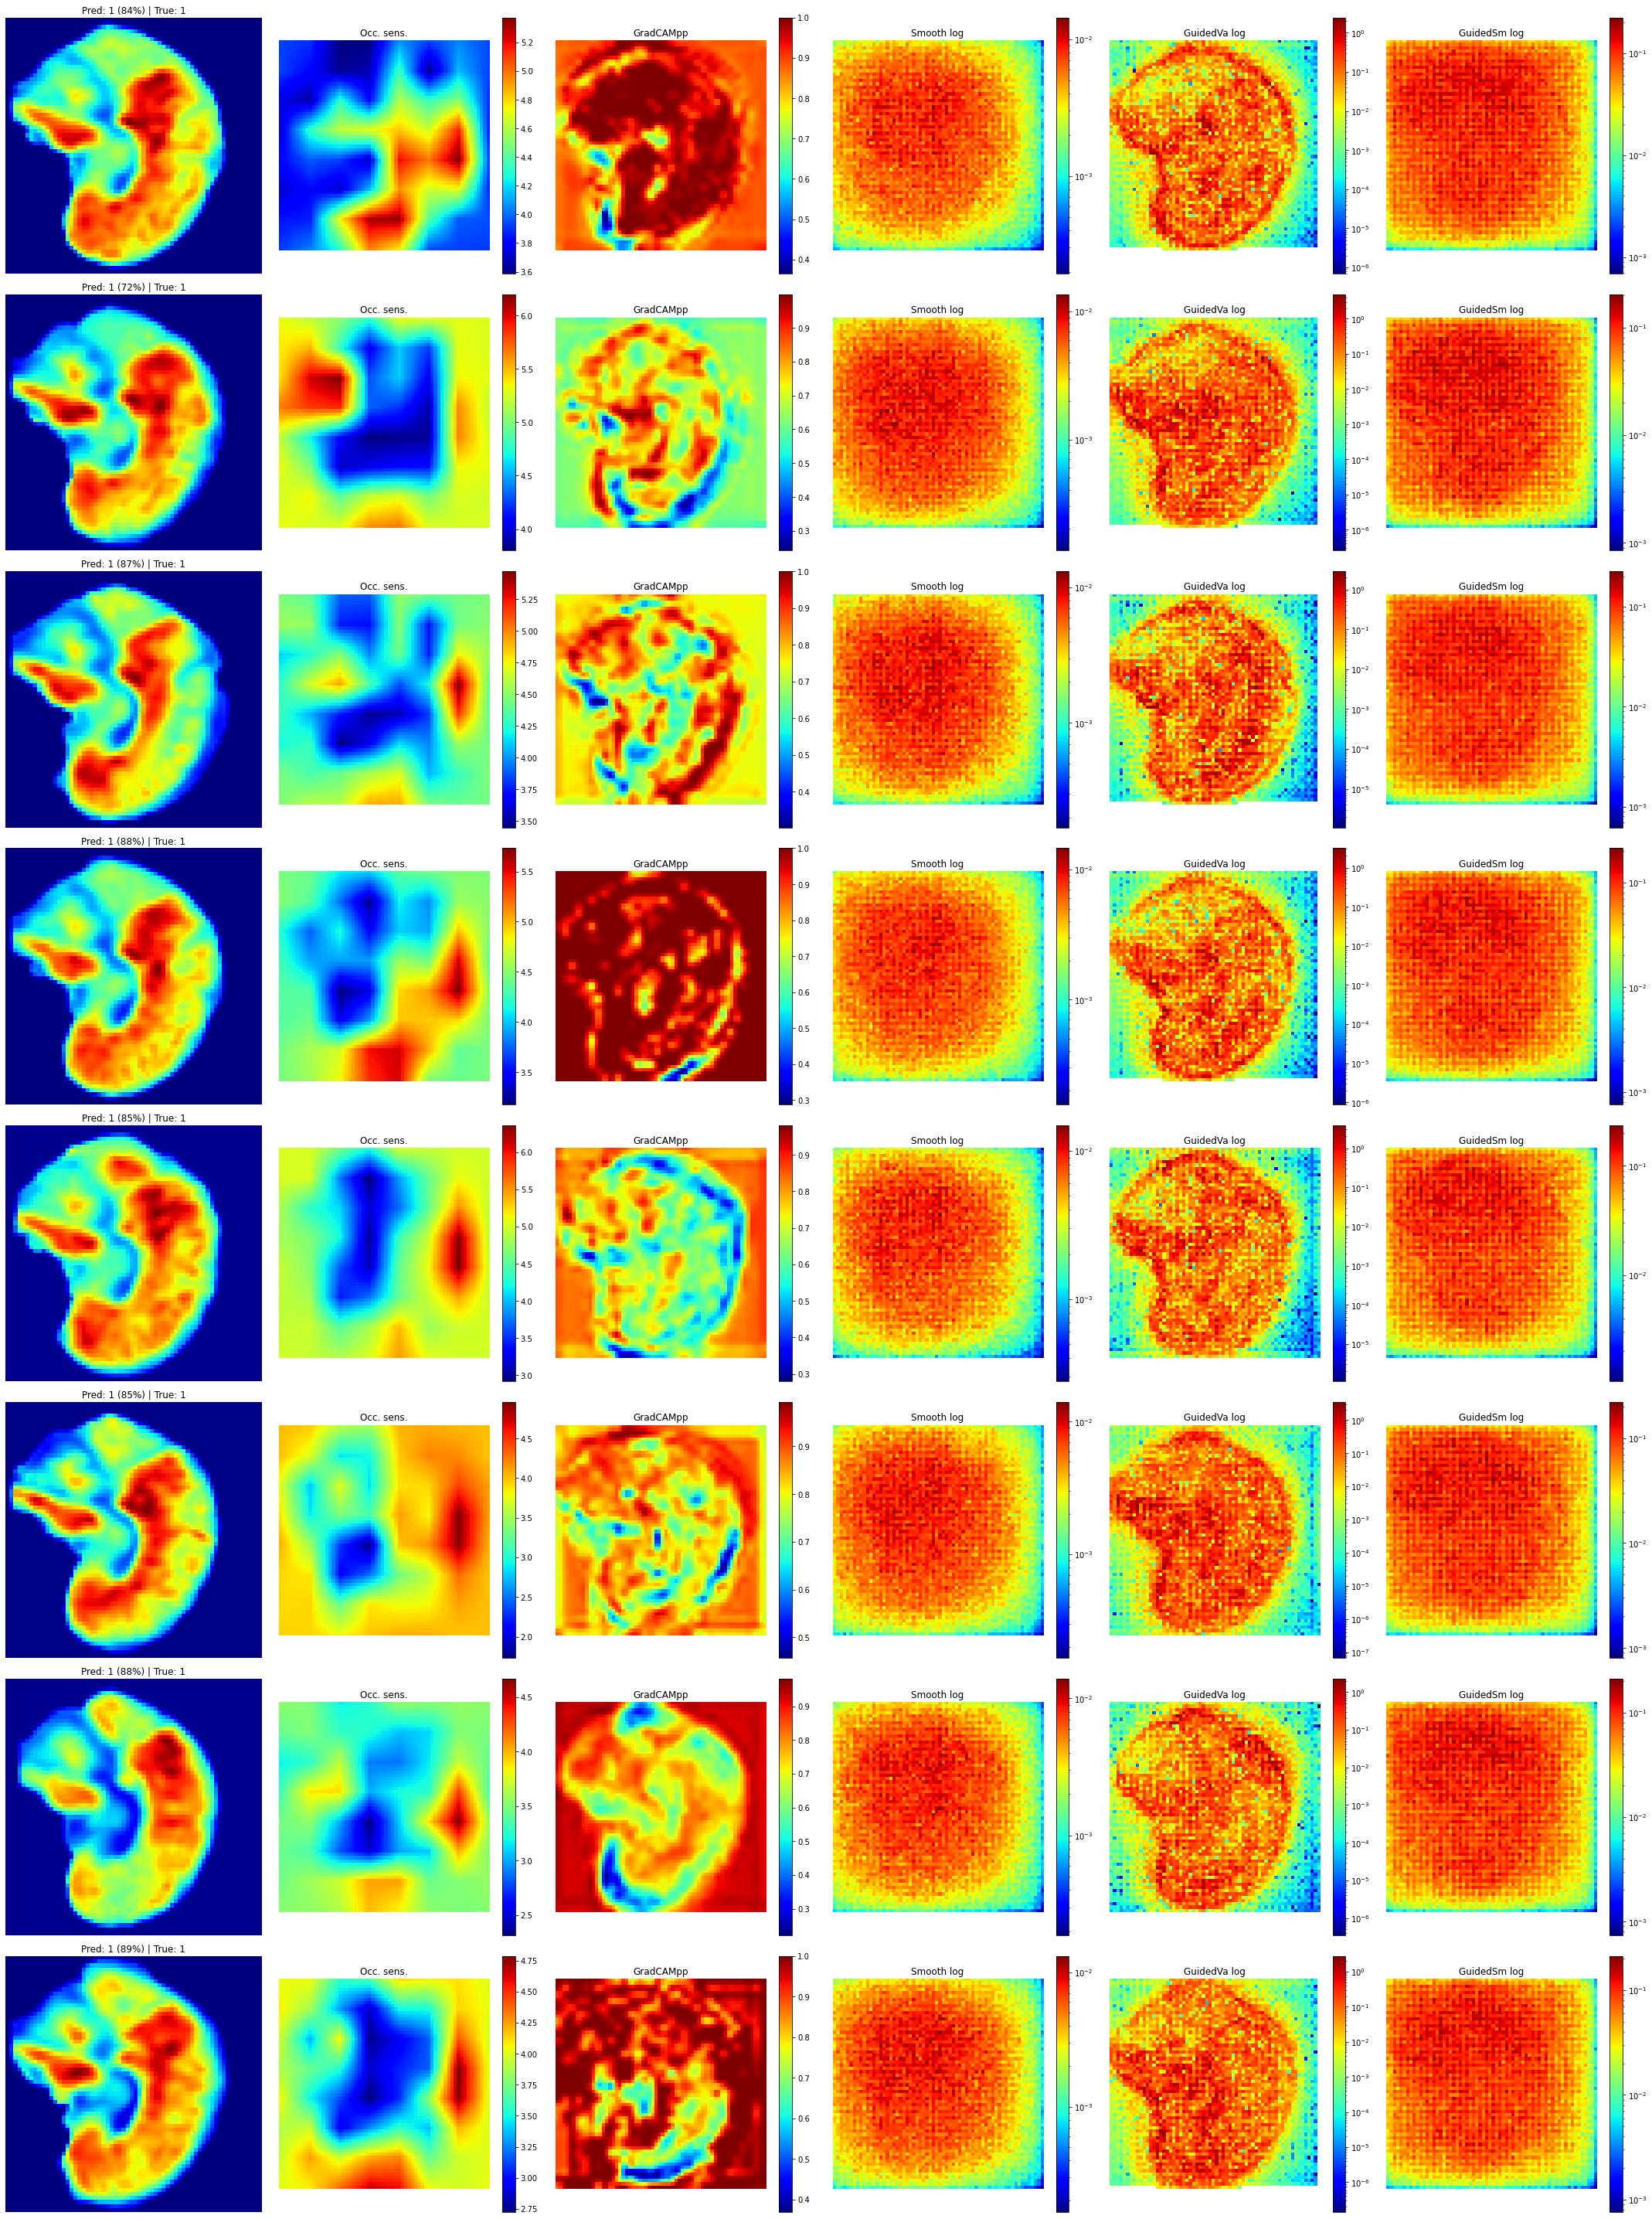

In [45]:
# target layer 1
for row, d in enumerate(tqdm.tqdm(test_subset)):
    ims, titles, log_scales = saliency(model, d, local_rank)
    if row == 0:
        num_cols = len(ims)
        subplot_shape = [num_examples, num_cols]
        figsize = [i * 5 for i in subplot_shape][::-1]
        fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')
    add_row(ims, titles, log_scales, row, axes, num_examples)
    
plt.tight_layout()
plt.show()

In [ ]:
# target layer 2
for row, d in enumerate(tqdm.tqdm(test_subset)):
    ims, titles, log_scales = saliency(model, d, local_rank)
    if row == 0:
        num_cols = len(ims)
        subplot_shape = [num_examples, num_cols]
        figsize = [i * 5 for i in subplot_shape][::-1]
        fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')
    add_row(ims, titles, log_scales, row, axes, num_examples)
    
plt.tight_layout()
plt.show()

100%|██████████| 8/8 [01:13<00:00,  9.13s/it]


In [ ]:
for row, d in enumerate(tqdm.tqdm(rand_data)):
    ims, titles, log_scales = saliency(model, d, local_rank)
    if row == 0:
        num_cols = len(ims)
        subplot_shape = [num_examples, num_cols]
        figsize = [i * 5 for i in subplot_shape][::-1]
        fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')
    add_row(ims, titles, log_scales, row, axes, num_examples)
plt.tight_layout()
plt.show()

In [ ]:
def saliency(model, d, device):
    ims = []
    titles = []
    log_scales = []

    img = torch.as_tensor(d["x"])[None].to(device)
    pred_logits = model(img)
    pred_label = pred_logits.argmax(dim=1).item()
    pred_prob = int(torch.nn.functional.softmax(pred_logits, dim=1)[0, pred_label].item() * 100)
    # Image
    ims.append(torch.moveaxis(img, 1, -1))
    titles.append(f"Pred: {pred_label} ({pred_prob}%) | True: {d['y']}")
    log_scales.append(False)

    # other gradient-based approaches
    out = guided_vanilla(img)
    out = torch.sum(out ** 2, dim=1) ** 0.5  # RGB -> scalar
    ims.append(out)
    titles.append("Guided")
    log_scales.append(True)

    return ims, titles, log_scales

In [ ]:
def add_im(im, title, log_scale, row, col, num_examples, cmap):
    ax = axes[row, col] if num_examples > 1 else axes[col]
    if isinstance(im, torch.Tensor):
        im = im.detach().cpu()
    if log_scale:
        im_show = ax.imshow(im[0], cmap=cmap, norm=colors.LogNorm())
        title += " log"
    else:
        im_show = ax.imshow(im[0], cmap=cmap)
    ax.set_title(title)
    ax.axis("off")
    if col > 0:
        fig.colorbar(im_show, ax=ax)


def add_row(ims, titles, log_scales, row, axes, num_examples):
    for col, (im, title, log_scale) in enumerate(zip(ims, titles, log_scales)):
        cmap = 'binary' if col == 0 else 'jet'
        if log_scale and im.min() < 0:
            im -= im.min()
        IMG = im[:, 32, :]
        add_im(IMG, title, log_scale, row, col, num_examples, cmap)

In [ ]:
for row, d in enumerate(tqdm.tqdm(rand_data)):
    ims, titles, log_scales = saliency(model, d, local_rank)
    if row == 0:
        num_cols = len(ims)
        subplot_shape = [num_examples, num_cols]
        figsize = [i * 3 for i in subplot_shape][::-1]
        fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')
    add_row(ims, titles, log_scales, row, axes, num_examples)
plt.tight_layout()